Requirements

`cv2` (`pip install opencv-python`) <br>
`scikit-image.__version__` >= 14.0

In [1]:
# Description:
#   Exercise4 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

# Preparations
from PIL import Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
from itertools import compress

from scipy.ndimage import maximum_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import convolve1d as conv1
from scipy.ndimage.filters import convolve as conv2

from skimage.io import imread
from skimage.transform import ProjectiveTransform, SimilarityTransform, AffineTransform
from skimage.measure import ransac

from utils import gaussian2, maxinterp, circle_points

import time

## Exercise 1 - Matching Harris corner points
In this exercise, you will familiarize yourself with the method of Harris interest point detection. The aim is to first detect Harris corners from two images of the same scene. Then, image patches of size 15x15 pixels around each detected corner point is extracted following a matching step where mutually nearest neighbors are found using the sum of squared differences (SSD) similarity measure. <br><br>
The SSD measure for two image patches, $f$ and $g$, is defined as follows<br><br>

<center>$SSD(f,g) = \sum_{k,l}(g(k,l)-f(k,l))^{2}$</center> 
so that the larger the SSD value the more dissimilar the patches are.
<br><br>
Do the task (a) below and answer questions in (b):



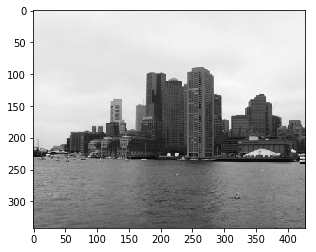

In [2]:
## The first part uses OpenCV computer vision library to
## extract Harris corner points
## (source: https://docs.opencv.org/3.0-beta/doc/py_tutorials/
## py_feature2d/py_features_harris/py_features_harris.html)
I1 = imread('assets/Boston1.png');
plt.imshow(I1, cmap='gray')

In [3]:
from cv2 import cornerHarris

- src - Input image, it should be grayscale and float32 type.
- blockSize - It is the size of neighbourhood considered for corner detection
- ksize - Aperture parameter of Sobel derivative used.
- k - Harris detector free parameter in the equation.

In [4]:
R1 = cornerHarris(src=I1, blockSize=2, ksize=3, k=0.04)

In [5]:
# Take only the local maxima of the corner response function
# footprint is a boolean array that specifies (implicitly) a shape, 
# but also which of the elements within this shape will get passed to the filter function. 
fp = np.ones((3,3))
fp[1,1] = 0

# The maximum filter is defined as the maximum of all pixels 
# within a local region of an image.
# to remove negative outlier noise.
maxNR1 = maximum_filter(R1, footprint=fp, mode='constant')

In [6]:
# Test if cornerness is larger than neighborhood
cornerI1 = R1>maxNR1
cornerI1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

In [7]:
# Threshold for low value maxima
maxCV1 = np.amax(R1)
maxCV1

0.01684115

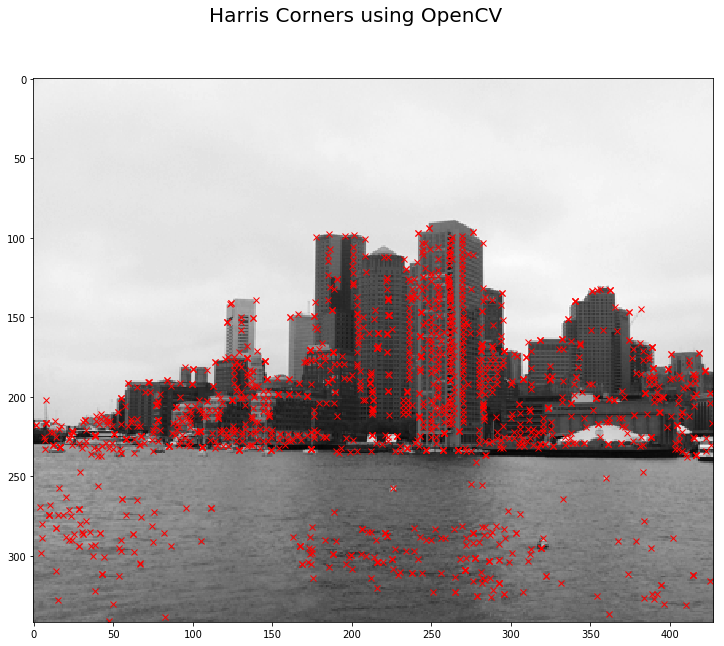

In [8]:
# Find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8((R1>0.0001*maxCV1)*cornerI1))

# Define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(I1,np.float32(centroids),(5,5),(-1,-1), criteria)
kp1=corners.T

# Display Harris keypoints
plt.figure(figsize=(20,10))
plt.imshow(I1, cmap='gray')
plt.plot([kp1[0]],[kp1[1]],'rx')
plt.suptitle("Harris Corners using OpenCV", fontsize=20)
plt.show()

where M is a second moment matrix computed from image
derivatives:

$$
M = \begin{bmatrix}
    \sum_{x,y} I_x^2       & \sum_{x,y} I_x I_y  \\
    \sum_{x,y} I_x I_y        & \sum_{x,y} I_y^2 
\end{bmatrix} $$

Directions with greatest/ smallest change

Diagonalization of M:

$$
M = R^{-1} \begin{bmatrix}
    \lambda_1       & 0 \\
    0        &  \lambda_2 
\end{bmatrix} R $$


### Corner detection

- $\lambda_1$ and $\lambda_2$ are small: Flat region
- $\lambda_1$ >> $\lambda_2$: Edge
- $\lambda_2$ >> $\lambda_1$: Edge
- $\lambda_1$ and $\lambda_2$ are **LARGE**, $\lambda_1 \approx \lambda_2$: Corner

### Corner response function
$$ R = det(M) - \alpha \times trace(M)^2 = \lambda_1 \lambda_2 - \alpha (\lambda_1 + \lambda_2)$$

- |R| small: Flat region
- R < 0: Edge
- R > 0 : Corner

# Harris corner detector
1. Compute partial derivatives at each pixel
2. Compute second moment matrix M in a Gaussian window around each pixel:
$$
M = \begin{bmatrix}
    \sum_{x,y} w(x,y) I_x^2       & \sum_{x,y} w(x,y) I_x I_y  \\
    \sum_{x,y} w(x,y) I_x I_y        & \sum_{x,y} w(x,y) I_y^2 
\end{bmatrix} $$
3. Compute corner response function R
4. Threshold R
5. Find local maxima of response function (nonmaximum suppression)

In [9]:
## The previous part illustrated OpenCV's built-in capabilities.
## Let's try to do Harris corner extraction and matching using our own
## implementation in a less black-box manner.

## Familiarize yourself with the harris function
def harris(im, sigma=1.0, relTh=0.0001, k=0.04):
    im = im.astype(np.float) # Make sure im is float
    
    # Get smoothing and derivative filters
    g, _, _, _, _, _, = gaussian2(sigma)
    _, gx, gy, _, _, _, = gaussian2(np.sqrt(0.5))
    
    # Partial derivatives
    Ix = conv2(im, -gx, mode='constant')
    Iy = conv2(im, -gy, mode='constant')
    
    # Components of the second moment matrix
    Ix2Sm = conv2(Ix**2, g, mode='constant')
    Iy2Sm = conv2(Iy**2, g, mode='constant')
    IxIySm = conv2(Ix*Iy, g, mode='constant')
    
    # Determinant and trace for calculating the corner response
    detC = (Ix2Sm*IxIySm)-(Iy2Sm**2)
    traceC = Ix2Sm+IxIySm
    
    # Corner response function R
    # "Corner": R > 0
    # "Edge": R < 0
    # "Flat": |R| = small
    R = detC-k*traceC**2
    maxCornerValue = np.amax(R)
    
    # Take only the local maxima of the corner response function
    fp = np.ones((3,3))
    fp[1,1] = 0
    maxImg = maximum_filter(R, footprint=fp, mode='constant')
    
    # Test if cornerness is larger than neighborhood
    cornerImg = R>maxImg
    
    # Threshold for low value maxima
    y, x = np.nonzero((R>relTh*maxCornerValue)*cornerImg) 
    
    # Convert to float
    x = x.astype(np.float)
    y = y.astype(np.float)
    
    # Remove responses from image borders to reduce false corner detections
    r, c = R.shape
    idx = np.nonzero((x<2)+(x>c-3)+(y<2)+(y>r-3))[0]
    x = np.delete(x,idx)
    y = np.delete(y,idx)
    
    # Parabolic interpolation
    for i in range(len(x)):
        _,dx=maxinterp((R[int(y[i]), int(x[i])-1], R[int(y[i]), int(x[i])], R[int(y[i]), int(x[i])+1]))
        _,dy=maxinterp((R[int(y[i])-1, int(x[i])], R[int(y[i]), int(x[i])], R[int(y[i])+1, int(x[i])]))
        x[i]=x[i]+dx
        y[i]=y[i]+dy
        
    return x, y, cornerImg

def maxinterp(v):
    a = 0.5*v[0] - v[1] + 0.5*v[2]
    b = -0.5*v[0] + 0.5*v[2]
    c = v[1]
    
    loc = (-b/2.0/a) 
    m = np.dot(np.array([a,b,c]), np.array([loc**2, loc, 1]))
    return m, loc

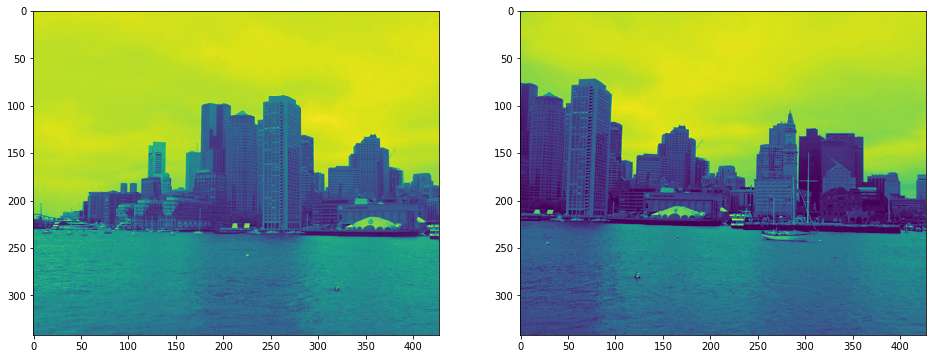

In [10]:
# Load images
I1 = imread('assets/Boston1.png')/255.
I2 = imread('assets/Boston2m.png')/255.

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))

axes[0].imshow(I1)
axes[1].imshow(I2)

plt.show()

In [11]:
# Harris corner extraction, take a look at the source code above
x1, y1, cimg1 = harris(I1)
x2, y2, cimg2 = harris(I2)

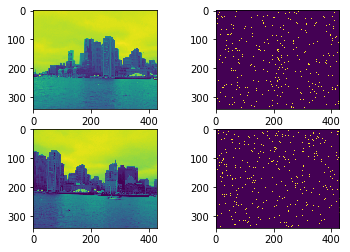

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0][0].imshow(I1)
axes[0][1].imshow(cimg1)

axes[1][0].imshow(I2)
axes[1][1].imshow(cimg2)

In [13]:
x1.shape, y1.shape, cimg1.shape

((214,), (214,), (342, 428))

In [14]:
x2.shape, y2.shape, cimg2.shape

((254,), (254,), (342, 428))

In [15]:
## We pre-allocate the memory for the 15*15 image patches extracted
## around each corner point from both images
patch_size=15
npts1=x1.shape[0]
npts2=x2.shape[0]
patches1=np.zeros((patch_size, patch_size, npts1))
patches2=np.zeros((patch_size, patch_size, npts2))

patches1.shape, patches2.shape

# what is the zeros

((15, 15, 214), (15, 15, 254))

In [16]:
# map_coordinates function interpolates values between elements (using non-int index)
## The following part extracts the patches using bilinear interpolation
k=(patch_size-1)/2.
xv,yv=np.meshgrid(np.arange(-k,k+1),np.arange(-k, k+1))
for i in range(npts1):
    patch = map_coordinates(I1, (yv + y1[i], xv + x1[i]))
    patches1[:,:,i] = patch
for i in range(npts2):
    patch = map_coordinates(I2, (yv + y2[i], xv + x2[i]))
    patches2[:,:,i] = patch

The SSD measure for two image patches, $f$ and $g$, is defined as follows<br><br>

<center>$SSD(f,g) = \sum_{k,l}(g(k,l)-f(k,l))^{2}$</center> 
so that the **larger** the SSD value the more **dissimilar** the patches are.

the **smaller** the SSD value the more **similar** the patches are 

!important

In [17]:
## We compute the sum of squared differences (SSD) of pixels' intensities
## for all pairs of patches extracted from the two images
distmat = np.zeros((npts1, npts2))
for i1 in range(npts1):
    for i2 in range(npts2):
        distmat[i1,i2]=np.sum((patches1[:,:,i1]-patches2[:,:,i2])**2)

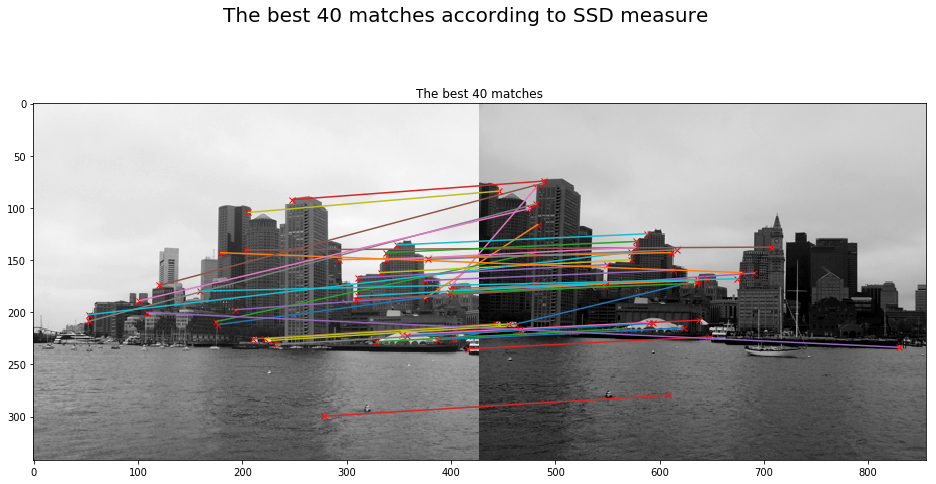

In [18]:
## Next we compute pairs of patches that are mutually nearest neighbors
## according to the SSD measure
ss1 = np.amin(distmat, axis=1)
ids1 = np.argmin(distmat, axis=1)
ss2 = np.amin(distmat, axis=0)
ids2 = np.argmin(distmat, axis=0)

pairs = []
for k in range(npts1):
    if k == ids2[ids1[k]]:
        pairs.append(np.array([k, ids1[k], ss1[k]]))
pairs = np.array(pairs)

## We sort the mutually nearest neighbors based on the SSD
sorted_ssd = np.sort(pairs[:,2], axis=0)
id_ssd = np.argsort(pairs[:,2], axis=0)

## Estimate the geometric transformation between images
src=[]
dst=[]
for k in range(len(id_ssd)):
    l = id_ssd[k]
    src.append([x1[int(pairs[l, 0])], y1[int(pairs[l, 0])]])
    dst.append([x2[int(pairs[l, 1])], y2[int(pairs[l, 1])]])
src=np.array(src)
dst=np.array(dst)
rthrs=2
tform,_ = ransac((src, dst), ProjectiveTransform, min_samples=4,
                               residual_threshold=rthrs, max_trials=1000)
H1to2p = tform.params

## Next we visualize the 40 best matches which are mutual nearest neighbors
## and have the smallest SSD values
Nvis = 40
montage = np.concatenate((I1, I2), axis=1)

plt.figure(figsize=(16, 8))
plt.suptitle("The best 40 matches according to SSD measure", fontsize=20)
plt.imshow(montage, cmap='gray')
plt.title('The best 40 matches')
for k in range(np.minimum(len(id_ssd), Nvis)):
    l = id_ssd[k]
    plt.plot(x1[int(pairs[l, 0])], y1[int(pairs[l, 0])], 'rx')
    plt.plot(x2[int(pairs[l, 1])] + I1.shape[1], y2[int(pairs[l, 1])], 'rx')
    plt.plot([x1[int(pairs[l, 0])], x2[int(pairs[l, 1])]+I1.shape[1]], 
         [y1[int(pairs[l, 0])], y2[int(pairs[l, 1])]])

In [19]:
## Finally, since we have estimated the planar projective transformation
## we can check that how many of the nearest neighbor matches actually
## are correct correspondences
p1to2=np.dot(H1to2p, np.hstack((src, np.ones((src.shape[0],1)))).T)
p1to2 = p1to2[:2,:] / p1to2[2,:]
p1to2 = p1to2.T
pdiff=np.sqrt(np.sum((dst-p1to2)**2, axis=1))

# The criterion for the match being a correct is that its correspondence in
# the second image should be at most rthrs=2 pixels away from the transformed
# location
n_correct = len(pdiff[pdiff<rthrs])
print("{} correct matches.".format(n_correct))

24 correct matches.


### a) Matching points using normalized cross-correlation (NCC)
Implement the matching of mutually nearest neighbors using normalized cross-correlation
(NCC) as the similarity measure instead of SSD. <br><br>

For two image patches of similar size it can be written as follows (also given in the slide 97 of
Lecture 2):
<br><br>
<center>$NCC(f,g) = \frac{\sum_{k,l}(g(k,l)-\bar{g})(f(k,l)-\bar{f})}{\sqrt{\sum_{k,l}(g(k,l)-\bar{g})^{2}\sum_{k,l}(f(k,l)-\bar{f})^{2}}}$
</center> <br><br>
where $\bar{g}$ and $\bar{f}$ are the mean intensity values of patches $g$ and $f$. The values of NCC are
always between -1 and 1, and the larger the value the more similar the patches are.

In [20]:
## Now, your task is to do matching in similar manner but using normalised 
## cross-correlation (NCC) instead of SSD. You should also report the 
## number of correct correspondences for NCC as shown above for SSD.
##
## HINT: Compared to the previous SDD-based implementation, all you need 
## to do is to modify the lines performing the 'distmat' calculation
## from SSD to NCC.
## Thereafter, you can proceed as above but notice the following details:
## You need to determine the mutually nearest neighbors by
## finding pairs for which NCC is maximized (i.e. not minimized like SSD).
## Also, you need to sort the matches in descending order in terms of NCC
## in order to find the best matches (i.e. not ascending order as with SSD). 

# Measure pairwise distances NCC
##-your-code-starts-here-##

# Load images
I1 = imread('assets/Boston1.png')/255.
I2 = imread('assets/Boston2m.png')/255.

# Harris corner extraction, take a look at the source code above
x1, y1, cimg1 = harris(I1)
x2, y2, cimg2 = harris(I2)

In [21]:
## We pre-allocate the memory for the 15*15 image patches extracted
## around each corner point from both images
patch_size=15
npts1=x1.shape[0]
npts2=x2.shape[0]
patches1=np.zeros((patch_size, patch_size, npts1))
patches2=np.zeros((patch_size, patch_size, npts2))

## The following part extracts the patches using bilinear interpolation
k=(patch_size-1)/2.
xv,yv=np.meshgrid(np.arange(-k,k+1),np.arange(-k, k+1))
for i in range(npts1):
    patch = map_coordinates(I1, (yv + y1[i], xv + x1[i]))
    patches1[:,:,i] = patch
for i in range(npts2):
    patch = map_coordinates(I2, (yv + y2[i], xv + x2[i]))
    patches2[:,:,i] = patch

Instead of using **SSD** (Recall:

<center>$SSD(f,g) = \sum_{k,l}(g(k,l)-f(k,l))^{2}$</center> 
so that the larger the SSD value the more dissimilar the patches are.
<br><br>
)

```
distmat = np.zeros((npts1, npts2))
for i1 in range(npts1):
    for i2 in range(npts2):
        distmat[i1,i2]=np.sum((patches1[:,:,i1]-patches2[:,:,i2])**2)
```

We can implement the matching of mutually nearest neighbors using normalized cross-correlation (NCC) as the similarity measure instead of SSD. 
<br><br>
<center>$NCC(f,g) = \frac{\sum_{k,l}(g(k,l)-\bar{g})(f(k,l)-\bar{f})}{\sqrt{\sum_{k,l}(g(k,l)-\bar{g})^{2}\sum_{k,l}(f(k,l)-\bar{f})^{2}}}$</center> <br><br>
where $\bar{g}$ and $\bar{f}$ are the mean intensity values of patches $g$ and $f$.

The values of NCC are always between -1 and 1, and the **larger the value the more similar the patches are**.

In [31]:
distmat = np.zeros((npts1, npts2))
for i1 in range(npts1):
    for i2 in range(npts2):
        g = patches1[:, :, i1]
        f = patches2[:, :, i2]
        
        g_mean = g.mean()
        f_mean = f.mean()

        g_minus_mean = np.subtract(g, g_mean)
        f_minus_mean = np.subtract(f, f_mean)
        
        numerator = np.sum(np.multiply(g_minus_mean, f_minus_mean))
        denominator = np.sqrt(np.multiply(np.sum(g_minus_mean ** 2),np.sum(f_minus_mean ** 2)))
        distmat[i1, i2] = numerator / denominator

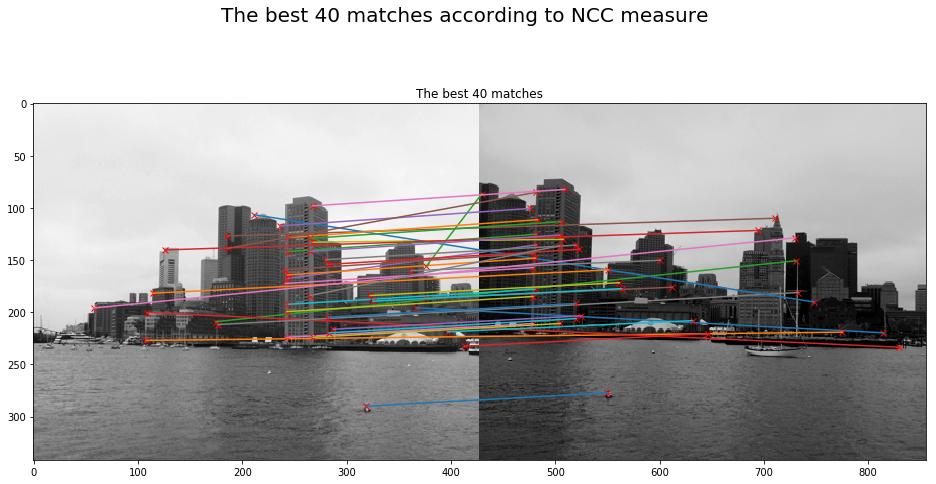

In [32]:
## Next we compute pairs of patches that are mutually nearest neighbors
## according to the SSD measure
# remember that the larger the more similar
ss1 = np.amax(distmat, axis=1)
ids1 = np.argmax(distmat, axis=1)
ss2 = np.amax(distmat, axis=0)
ids2 = np.argmax(distmat, axis=0)

pairs = []
for k in range(npts1):
    if k == ids2[ids1[k]]:
        pairs.append(np.array([k, ids1[k], ss1[k]]))
pairs = np.array(pairs)

## We sort the mutually nearest neighbors based on the SSD
sorted_ssd = np.sort(pairs[:,2], axis=0)
id_ssd = np.argsort(pairs[:,2], axis=0)

## Estimate the geometric transformation between images
src=[]
dst=[]
for k in range(len(id_ssd)):
    l = id_ssd[k]
    src.append([x1[int(pairs[l, 0])], y1[int(pairs[l, 0])]])
    dst.append([x2[int(pairs[l, 1])], y2[int(pairs[l, 1])]])
src=np.array(src)
dst=np.array(dst)
rthrs=2
tform,_ = ransac((src, dst), ProjectiveTransform, min_samples=4,
                               residual_threshold=rthrs, max_trials=1000)
H1to2p = tform.params



## Next we visualize the 40 best matches which are mutual nearest neighbors
## and have the smallest SSD values
Nvis = 40
montage = np.concatenate((I1, I2), axis=1)

    
plt.figure(figsize=(16, 8))
plt.suptitle("The best 40 matches according to NCC measure", fontsize=20)
plt.imshow(montage, cmap='gray')
plt.title('The best 40 matches')
for k in range(np.minimum(len(id_ssd), Nvis)):
    l = id_ssd[k]
    plt.plot(x1[int(pairs[l, 0])], y1[int(pairs[l, 0])], 'rx')
    plt.plot(x2[int(pairs[l, 1])] + I1.shape[1], y2[int(pairs[l, 1])], 'rx')
    plt.plot([x1[int(pairs[l, 0])], x2[int(pairs[l, 1])]+I1.shape[1]], 
         [y1[int(pairs[l, 0])], y2[int(pairs[l, 1])]])

In [33]:

## Finally, since we have estimated the planar projective transformation
## we can check that how many of the nearest neighbor matches actually
## are correct correspondences
p1to2=np.dot(H1to2p, np.hstack((src, np.ones((src.shape[0],1)))).T)
p1to2 = p1to2[:2,:] / p1to2[2,:]
p1to2 = p1to2.T
pdiff=np.sqrt(np.sum((dst-p1to2)**2, axis=1))

# The criterion for the match being a correct is that its correspondence in
# the second image should be at most rthrs=2 pixels away from the transformed
# location
n_correct = len(pdiff[pdiff<rthrs])
print("{} correct matches.".format(n_correct))
##-your-code-ends-here-##

82 correct matches.
